<a href="https://colab.research.google.com/github/JosegSuarezb/trabajo-final/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nombres:** Jose Gregorio Suarez Boada, Natalia Giraldo Mesa & Tania Lizeth Martínez Rondón

El objetivo del proyecto es aplicar técnicas de clustering para segmentar a los clientes en grupos homogéneos, basados en sus comportamientos de compra, donde esto permitirá a la empresa identificar a los clientes que compran productos de alta gama y con frecuencia, diferencias a los compradores ocasionales de los frecuentes y de esta manera enfocar las etrategias de marketing.

In [ ]:
import numpy as np
import pandas as pd
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)
from sklearn.decomposition import PCA # Análisis de componentes principales
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
from sklearn.ensemble import IsolationForest # Detección de atípicos
# Score de silueta
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/supermarket_sales.csv')
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [ ]:
data.isna().sum() # Cantidad de datos faltantes

,0
Invoice ID,0
Branch,0
City,0
Customer type,0
Gender,0
Product line,0
Unit price,0
Quantity,0
Tax 5%,0
Total,0


In [ ]:
data=data.dropna()

In [ ]:
data.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


# **Análisis exploratorio de los datos**

In [ ]:
# Boxplot con el total de ventas por ciudad

px.box(data, x='City', y='Total', #color="City",
       #points= False, # No muestra los puntos atípicos extendiendo las barras
             title='City Vs Total')

**Boxplot:** Esta gráfica muestra la distribución del total de ventas para cada ciudad. La ciudad que tiene mayores ventas es Naypyitaw, seguida por Mandalay y Yangon respectivamente.

In [ ]:
# Gráfico circular que muestra la proporción de ventas para cada línea de producto

product_line_counts = data['Product line'].value_counts()

fig = px.pie(values=product_line_counts.values, names=product_line_counts.index,
             title='Distribución de Ventas por Línea de Producto')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

**Gráfico circular:** Este gráfico muestra las distribución de ventas para cada línea de producto. Las tres líneas de prodcutos más vendidas son Fashion Accessories, Food and Beverage y Electronic Accessories, con porcentajes de 17.8%, 17.4% y 17% respectivamente.

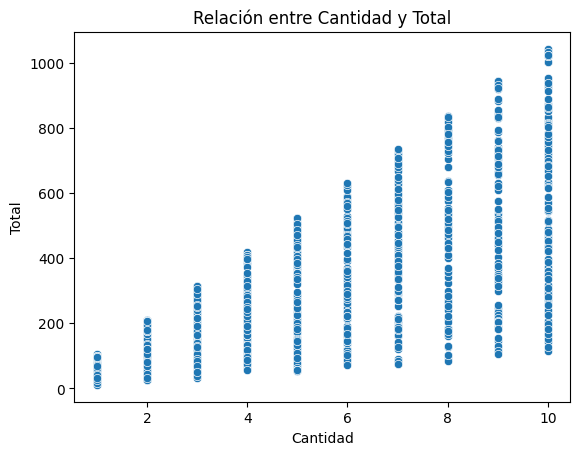

In [ ]:
# Relación entre cantidad y total de ventas

sns.scatterplot(x='Quantity', y='Total', data=data)
plt.title('Relación entre Cantidad y Total')
plt.xlabel('Cantidad')
plt.ylabel('Total')
plt.show()

**Scatterplot:** Esta gráfica muestra la relación entre la cantidad de prodcutos vendiddos y el total de ventas. Se observa que hay una correlación positiva entres las dos variables, lo que significa que entre más cantidad de productos vendidos, mayor el total de ventas.

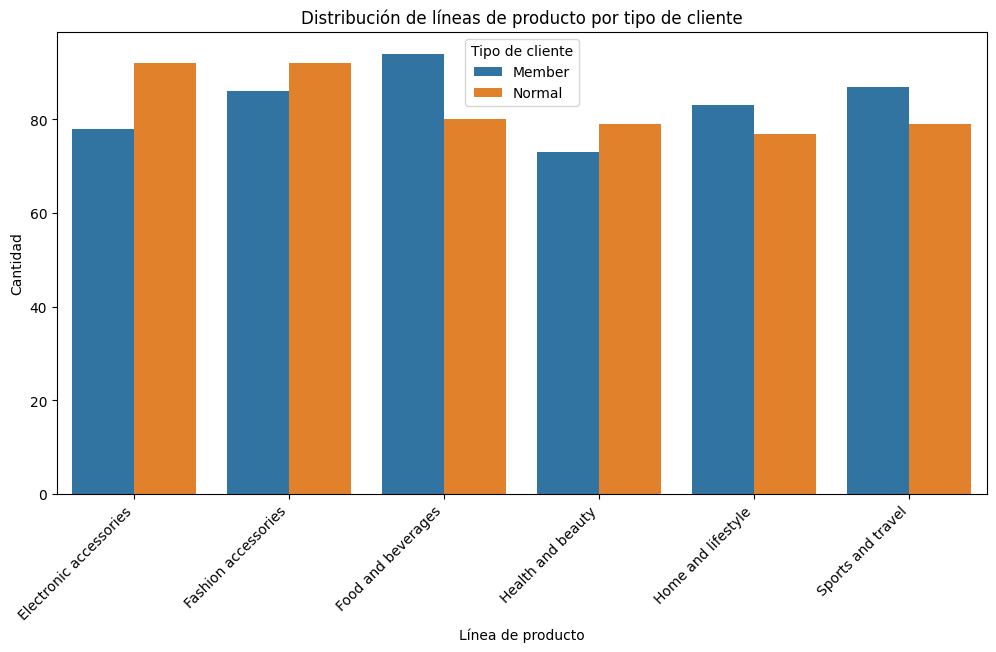

In [ ]:
# Preferencia de las líneas de producto por el tipo de cliente

grouped_data = data.groupby(['Product line', 'Customer type'])['Quantity'].count().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(x='Product line', y='Count', hue='Customer type', data=grouped_data)
plt.title('Distribución de líneas de producto por tipo de cliente')
plt.xlabel('Línea de producto')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
plt.legend(title='Tipo de cliente')
plt.show()

**Barplot:** Esta gráfica muestra la preferencia de las líneas de producto por el tipo de cliente. Se indentifica que las líneas preferidas por los clientes normales son Electronic Accessories, Fashion Accessories y Health and Beaty; mientras que las preferidas por lo clientes miembros son Food and Beverages, Home and Lifestyle and Sports and Travel.

In [ ]:
# Identificar variables numéricas
variables_numericas = data.select_dtypes(include=['number']).columns
print("Variables numéricas:", variables_numericas)

# Identificar variables categóricas
variables_categoricas = data.select_dtypes(include=['object', 'category']).columns
print("Variables categóricas:", variables_categoricas)

Variables numéricas: Index(['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs',
       'gross margin percentage', 'gross income', 'Rating'],
      dtype='object')
Variables categóricas: Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Date', 'Time', 'Payment'],
      dtype='object')


# **Implementación de Clustering sin limpieza**

## **K-means**

In [ ]:
#TRANSFORMACIÓN DE VARIABLES CATEGORICAS A DUMMY
Variables = ['Quantity', 'Total', 'Rating', 'City', 'Customer type', 'Gender',
       'Product line']

datos_numericos= pd.get_dummies(data[Variables], columns=['City', 'Customer type', 'Gender',
       'Product line'],dtype=int, drop_first=True )
datos_numericos

,Quantity,Total,Rating,City_Naypyitaw,City_Yangon,Customer type_Normal,Gender_Male,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel
0,7,548.9715,9.1,0,1,0,0,0,0,1,0,0
1,5,80.2200,9.6,1,0,1,0,0,0,0,0,0
2,7,340.5255,7.4,0,1,1,1,0,0,0,1,0
3,8,489.0480,8.4,0,1,0,1,0,0,1,0,0
4,7,634.3785,5.3,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,42.3675,6.2,1,0,1,1,0,0,1,0,0
996,10,1022.4900,4.4,0,0,1,0,0,0,0,1,0
997,1,33.4320,7.7,0,1,0,1,0,1,0,0,0
998,1,69.1110,4.1,0,1,1,1,0,0,0,1,0


In [ ]:
#ESTANDARIZAR LAS VARIABLES
scaler = StandardScaler()
scaled_features= scaler.fit_transform(datos_numericos)
pd.DataFrame(scaled_features, columns = datos_numericos.columns)

,Quantity,Total,Rating,City_Naypyitaw,City_Yangon,Customer type_Normal,Gender_Male,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel
0,0.509930,0.919607,1.238443,-0.698638,1.393261,-0.998002,-0.998002,-0.465344,-0.45897,2.361980,-0.436436,-0.44614
1,-0.174540,-0.987730,1.529527,1.431356,-0.717741,1.002002,-0.998002,-0.465344,-0.45897,-0.423374,-0.436436,-0.44614
2,0.509930,0.071446,0.248760,-0.698638,1.393261,1.002002,1.002002,-0.465344,-0.45897,-0.423374,2.291288,-0.44614
3,0.852165,0.675780,0.830927,-0.698638,1.393261,-0.998002,1.002002,-0.465344,-0.45897,2.361980,-0.436436,-0.44614
4,0.509930,1.267125,-0.973790,-0.698638,1.393261,1.002002,1.002002,-0.465344,-0.45897,-0.423374,-0.436436,2.24145
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.543480,-1.141750,-0.449840,1.431356,-0.717741,1.002002,1.002002,-0.465344,-0.45897,2.361980,-0.436436,-0.44614
996,1.536635,2.846340,-1.497741,-0.698638,-0.717741,1.002002,-0.998002,-0.465344,-0.45897,-0.423374,2.291288,-0.44614
997,-1.543480,-1.178109,0.423410,-0.698638,1.393261,-0.998002,1.002002,-0.465344,2.17879,-0.423374,-0.436436,-0.44614
998,-1.543480,-1.032932,-1.672391,-0.698638,1.393261,1.002002,1.002002,-0.465344,-0.45897,-0.423374,2.291288,-0.44614


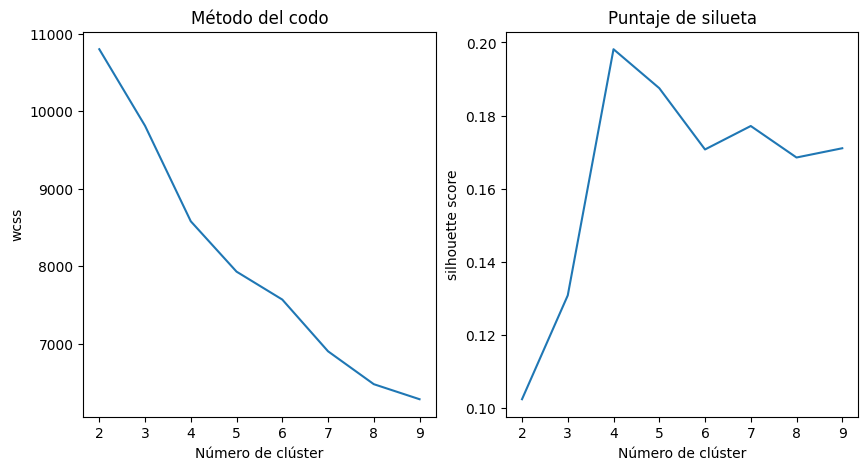

In [ ]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k, random_state=123)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [ ]:
k_means=KMeans(4, random_state=123  )
k_means.fit(scaled_features )
data["labels_k_means"]= k_means.labels_
data["labels_k_means"] = data["labels_k_means"].astype(str)
data["labels_k_means"].value_counts()

,count
labels_k_means,
3,496
1,178
0,166
2,160


labels_k_means
3    0.496
1    0.178
0    0.166
2    0.160
Name: proportion, dtype: float64


<Axes: xlabel='labels_k_means', ylabel='proportion'>

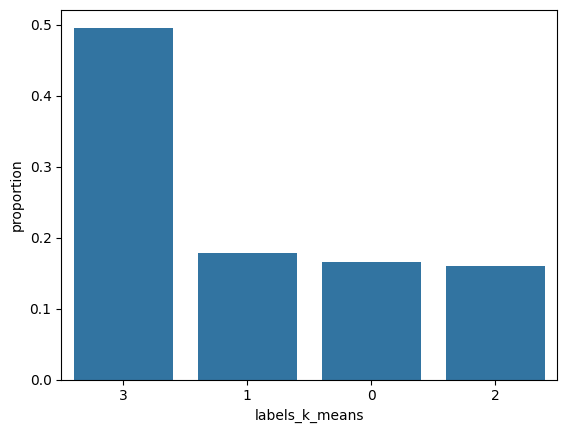

In [ ]:
print(data["labels_k_means"].value_counts(normalize=True))
sns.barplot(data["labels_k_means"].value_counts(normalize=True) )

## **Clúster jerarquico**

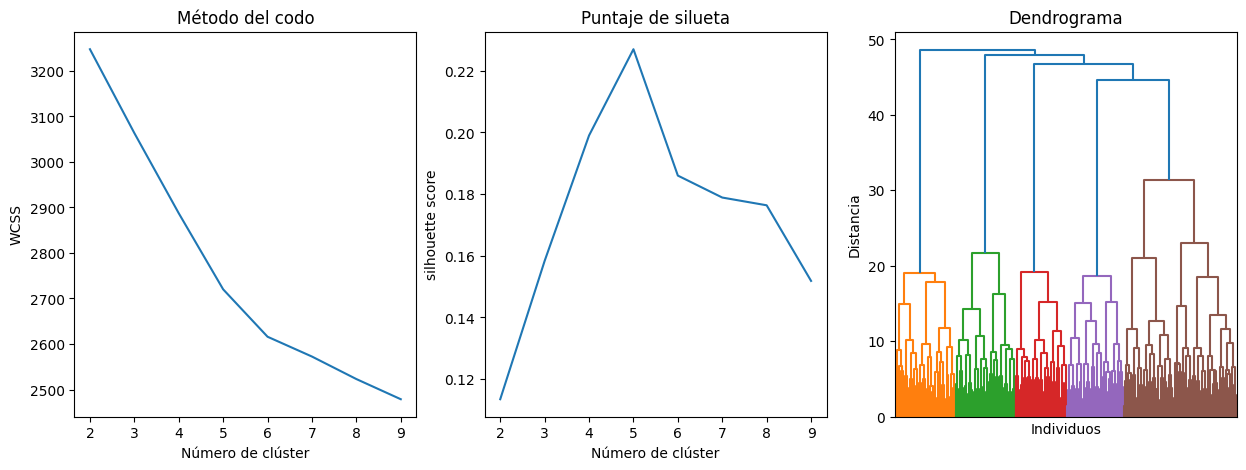

In [ ]:
#Cluster Jerarquico
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [ ]:
hc=AgglomerativeClustering(5)
hc.fit(scaled_features )
data["labels_hc"]= hc.labels_
data["labels_hc"] = data["labels_hc"].astype(str)
data["labels_hc"].value_counts()

,count
labels_hc,
0,330
3,178
2,174
4,166
1,152


labels_hc
0    0.330
3    0.178
2    0.174
4    0.166
1    0.152
Name: proportion, dtype: float64


<Axes: xlabel='labels_hc', ylabel='proportion'>

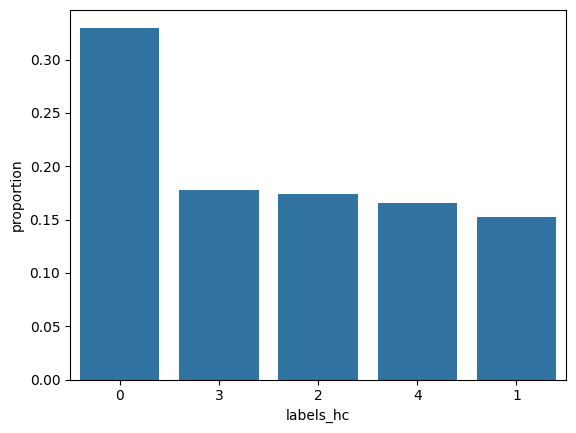

In [ ]:
print(data["labels_hc"].value_counts(normalize=True))
sns.barplot(data["labels_hc"].value_counts(normalize=True) )

# **Deteccion datos atipicos**

In [ ]:
modelo_atipicos = IsolationForest()
modelo_atipicos.fit(datos_numericos)
datos_numericos["atipico_isolation_forest"] = modelo_atipicos.predict(datos_numericos)
datos_numericos["atipico_isolation_forest"].value_counts()

,count
atipico_isolation_forest,
-1,874
1,126


In [ ]:
modelo_atipicos = IsolationForest(contamination= 0.01, random_state=123)
modelo_atipicos.fit(datos_numericos)
datos_numericos["atipico_isolation_forest"] = modelo_atipicos.predict(datos_numericos)
datos_numericos["atipico_isolation_forest"].value_counts()

,count
atipico_isolation_forest,
1,990
-1,10


In [ ]:
features_sin_atipicos = datos_numericos[datos_numericos["atipico_isolation_forest"]==1]

# **Reduccion de dimensionalidad con datos atipicos**

In [ ]:
num_variables= datos_numericos.shape[1]
scale_feature=StandardScaler().fit_transform( datos_numericos)
pca= PCA(num_variables )
pca.fit( scale_feature)

PCA(n_components=13)

In [ ]:
pd.DataFrame(pca.fit_transform( scale_feature)).corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000e+00,5.291818e-16,-1.037467e-16,7.137795e-17,-4.335551e-16,-1.656669e-17,2.208812e-16,-5.160066e-16,-1.435761e-16,-6.874290e-16,-1.141198e-15,-1.545440e-15,-5.264142e-16
1,5.291818e-16,1.000000e+00,-1.995847e-16,5.175641e-16,-2.928057e-16,1.299068e-15,-3.179016e-16,2.291014e-16,6.800021e-16,9.190880e-16,-4.268283e-15,3.510678e-16,-2.437243e-16
2,-1.037467e-16,-1.995847e-16,1.000000e+00,-1.687689e-16,-2.159794e-16,-1.574495e-16,-1.636126e-15,6.576711e-16,6.557432e-16,4.587596e-16,-4.802158e-16,-9.174902e-17,-2.461275e-16
3,7.137795e-17,5.175641e-16,-1.687689e-16,1.000000e+00,2.052186e-16,-4.941646e-16,-5.738154e-16,-1.768562e-16,-1.716534e-16,-9.291870e-17,5.547060e-16,2.331290e-16,1.889764e-15
4,-4.335551e-16,-2.928057e-16,-2.159794e-16,2.052186e-16,1.000000e+00,2.495885e-16,-1.080830e-16,3.243966e-16,-1.993545e-16,1.038840e-15,-3.875186e-16,1.145831e-16,-1.020911e-16
5,-1.656669e-17,1.299068e-15,-1.574495e-16,-4.941646e-16,2.495885e-16,1.000000e+00,4.653051e-16,-6.366954e-16,-5.648399e-16,-9.796486e-17,-1.966315e-15,-1.689761e-16,-2.494571e-15
6,2.208812e-16,-3.179016e-16,-1.636126e-15,-5.738154e-16,-1.080830e-16,4.653051e-16,1.000000e+00,-1.003345e-15,5.465410e-16,-2.267642e-16,-7.704472e-16,-1.331013e-16,1.301084e-16
7,-5.160066e-16,2.291014e-16,6.576711e-16,-1.768562e-16,3.243966e-16,-6.366954e-16,-1.003345e-15,1.000000e+00,7.983628e-16,-3.788490e-18,3.315645e-16,-1.301939e-16,-1.314975e-15
8,-1.435761e-16,6.800021e-16,6.557432e-16,-1.716534e-16,-1.993545e-16,-5.648399e-16,5.465410e-16,7.983628e-16,1.000000e+00,2.113835e-16,-1.064507e-16,2.459567e-16,7.720228e-16
9,-6.874290e-16,9.190880e-16,4.587596e-16,-9.291870e-17,1.038840e-15,-9.796486e-17,-2.267642e-16,-3.788490e-18,2.113835e-16,1.000000e+00,3.298066e-16,1.164316e-16,-8.455711e-17


In [ ]:
pca.explained_variance_

array([1.77463745, 1.5506518 , 1.24568954, 1.22245801, 1.20800192,
       1.16127773, 1.03220759, 0.99487672, 0.95627726, 0.88570236,
       0.4897273 , 0.28976115, 0.20174419])

In [ ]:
pd.Series(pca.explained_variance_ratio_)

,0
0,0.136374
1,0.119162
2,0.095726
3,0.093941
4,0.092830
5,0.089240
6,0.079321
7,0.076452
8,0.073486
9,0.068063


In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.13637406, 0.25553569, 0.35126214, 0.44520334, 0.53803364,
       0.62727336, 0.70659455, 0.783047  , 0.85653323, 0.92459605,
       0.96222971, 0.98449674, 1.        ])

Text(0, 0.5, 'Varianza explicada acumulada')

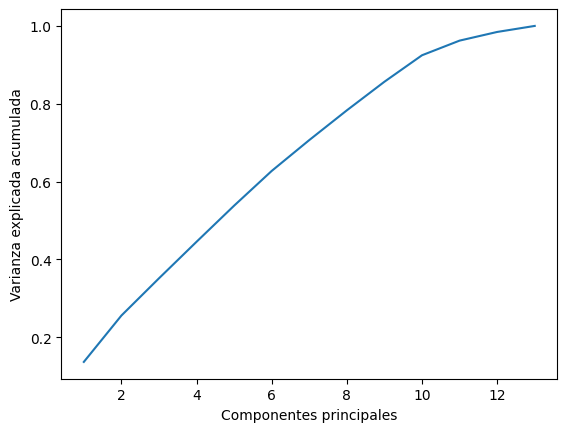

In [ ]:
sns.lineplot( x=range(1, num_variables+1), y=pca.explained_variance_ratio_.cumsum())
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada acumulada")

In [ ]:
pca= PCA(10)
pca.fit( scale_feature)

PCA(n_components=9)

In [ ]:
pd.DataFrame(pca.components_.T, index= datos_numericos.columns)

,0,1,2,3,4,5,6,7,8
Quantity,0.664313,-0.106306,0.064816,-0.034979,0.014900,-0.125466,-0.058445,0.069358,0.033502
Total,0.674629,-0.083805,0.055837,-0.043280,-0.012053,-0.126088,0.019136,-0.000165,-0.013338
Rating,-0.050871,0.060674,-0.049665,0.107071,0.045914,-0.226459,0.139056,0.853094,-0.412754
City_Naypyitaw,0.132995,0.649771,-0.053195,0.003107,0.008130,0.217337,0.090683,0.062425,-0.023507
City_Yangon,-0.114853,-0.645228,-0.008267,0.072140,-0.051757,-0.240559,-0.069552,0.031847,-0.032526
Customer type_Normal,-0.042570,-0.029726,-0.111631,-0.184195,0.017474,-0.157259,0.550565,0.247089,0.749055
Gender_Male,-0.102829,-0.108126,-0.335832,-0.111865,0.153754,-0.019090,0.461874,-0.238678,-0.355940
Product line_Fashion accessories,-0.107290,0.209866,0.247797,-0.365697,-0.491934,-0.506350,0.037010,-0.136888,-0.141355
Product line_Food and beverages,0.021219,0.111174,-0.197654,0.802364,0.012962,-0.238247,0.013949,-0.116231,0.137938
Product line_Health and beauty,0.019591,0.035558,-0.446771,-0.386854,0.555783,-0.123157,-0.327153,0.020921,0.022151


<Axes: >

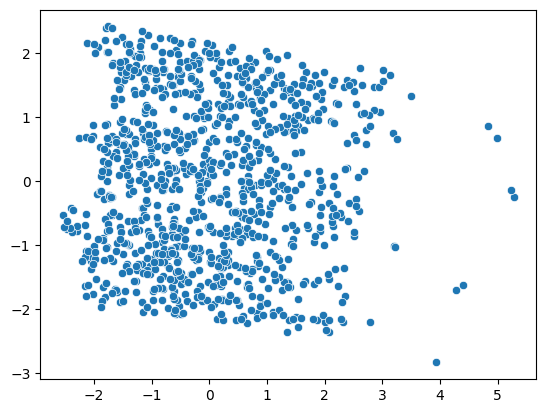

In [ ]:
z_componentes1= pca.fit_transform( scale_feature)

sns.scatterplot( x=z_componentes1[:,0], y=z_componentes1[:,1])


### K-Means

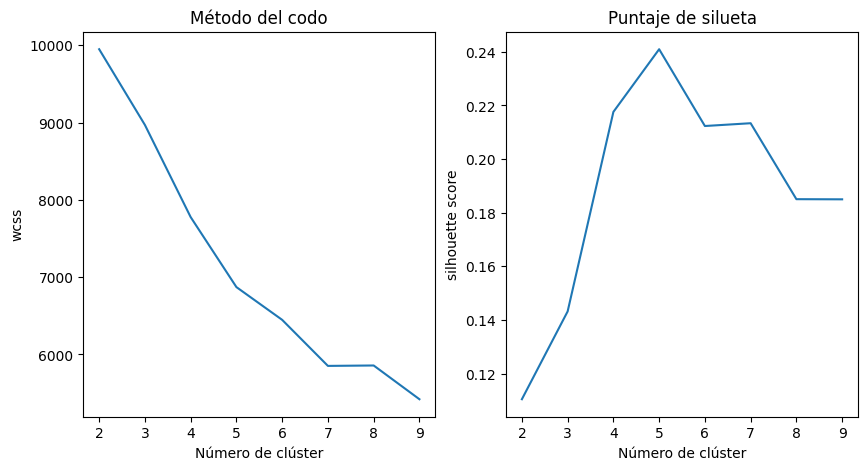

In [ ]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k, random_state=123)
  k_means.fit(z_componentes1)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(z_componentes1, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [ ]:
k_means= KMeans(5, random_state=123)
k_means.fit(z_componentes1)
labels_k_means2 = pd.Series(k_means.labels_)

#Frecuencia
counts = labels_k_means2.value_counts()
frequencies = labels_k_means2.value_counts(normalize=True) * 100

pd.DataFrame({'Counts': counts, 'Frequency (%)': frequencies})

,Counts,Frequency (%)
1,288,28.8
4,221,22.1
3,174,17.4
0,166,16.6
2,151,15.1


### Cluster Jerárquico

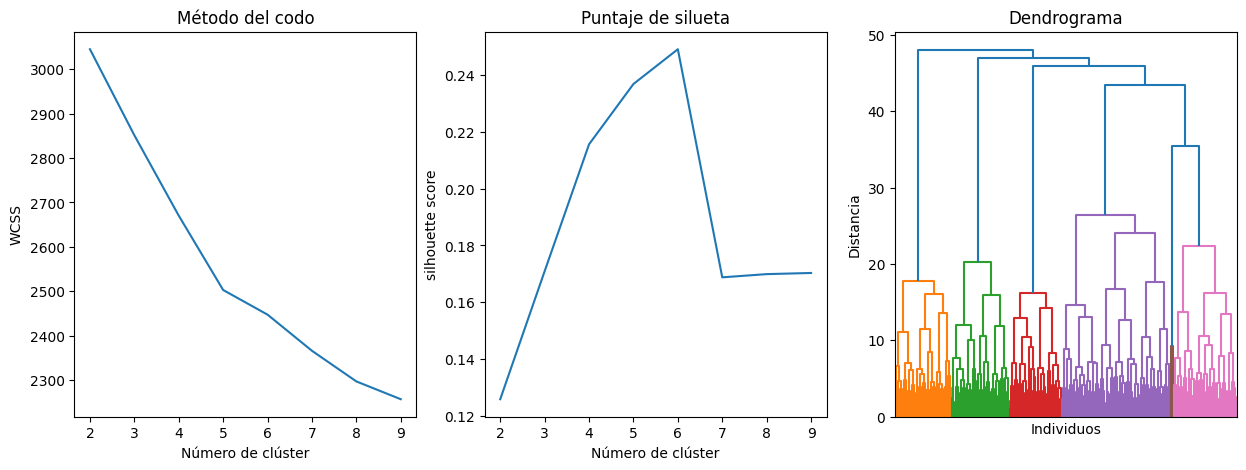

In [ ]:
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(z_componentes1)
  scaled_temp= pd.DataFrame(z_componentes1)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(z_componentes1,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(z_componentes1,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(z_componentes1, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [ ]:
hc=AgglomerativeClustering(5 )
hc.fit(z_componentes1 )
Labels_HC2 = pd.Series(hc.labels_)

#Frecuencia
counts = Labels_HC2.value_counts()
frequencies = Labels_HC2.value_counts(normalize=True) * 100

pd.DataFrame({'Counts': counts, 'Frequency (%)': frequencies})

,Counts,Frequency (%)
1,319,31.9
0,194,19.4
2,171,17.1
4,166,16.6
3,150,15.0


# **Reduccion de dimensionalidad sin datos atipicos**

In [ ]:
num_variables= datos_numericos.shape[1]
scale_feature=StandardScaler().fit_transform( features_sin_atipicos)
pca= PCA(num_variables )
pca.fit( scale_feature)

PCA(n_components=13)

In [ ]:
pd.DataFrame(pca.fit_transform( scale_feature)).corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000e+00,4.257907e-16,8.251424e-17,2.033749e-16,6.089813e-17,-3.529903e-17,-1.291689e-16,-3.715722e-16,-7.359630e-16,-2.922416e-16,-1.702524e-15,-3.701962e-16,NaN
1,4.257907e-16,1.000000e+00,-2.767042e-16,2.371287e-16,1.517194e-16,5.563560e-17,1.327877e-16,-1.944069e-16,-3.374811e-16,-1.124047e-15,7.891544e-17,8.583226e-16,NaN
2,8.251424e-17,-2.767042e-16,1.000000e+00,-4.143221e-16,1.930970e-15,3.088797e-16,-3.559731e-16,1.580627e-17,5.348291e-16,1.003329e-16,-2.734000e-16,3.112396e-15,NaN
3,2.033749e-16,2.371287e-16,-4.143221e-16,1.000000e+00,-6.162785e-16,7.143224e-16,6.677285e-16,-3.913064e-16,1.869283e-17,-2.434784e-16,4.363604e-16,-3.077304e-15,NaN
4,6.089813e-17,1.517194e-16,1.930970e-15,-6.162785e-16,1.000000e+00,-9.315134e-16,-4.869702e-16,2.078514e-16,-3.172510e-16,3.905998e-17,2.538487e-16,-1.715823e-15,NaN
5,-3.529903e-17,5.563560e-17,3.088797e-16,7.143224e-16,-9.315134e-16,1.000000e+00,-8.328199e-16,-5.119608e-16,-7.161587e-16,-6.675240e-16,4.587222e-16,-1.706123e-15,NaN
6,-1.291689e-16,1.327877e-16,-3.559731e-16,6.677285e-16,-4.869702e-16,-8.328199e-16,1.000000e+00,1.482888e-15,2.456179e-17,3.155511e-16,-1.024406e-18,-1.179654e-15,NaN
7,-3.715722e-16,-1.944069e-16,1.580627e-17,-3.913064e-16,2.078514e-16,-5.119608e-16,1.482888e-15,1.000000e+00,1.191819e-15,1.488678e-16,7.033114e-17,-1.274253e-15,NaN
8,-7.359630e-16,-3.374811e-16,5.348291e-16,1.869283e-17,-3.172510e-16,-7.161587e-16,2.456179e-17,1.191819e-15,1.000000e+00,-4.980370e-17,1.378599e-16,-1.141897e-15,NaN
9,-2.922416e-16,-1.124047e-15,1.003329e-16,-2.434784e-16,3.905998e-17,-6.675240e-16,3.155511e-16,1.488678e-16,-4.980370e-17,1.000000e+00,-6.731087e-17,9.033465e-17,NaN


In [ ]:
pca.explained_variance_

array([1.74275953, 1.55497645, 1.22501423, 1.22213299, 1.1984353 ,
       1.15434247, 1.00129334, 0.97649348, 0.93760159, 0.49501557,
       0.29982138, 0.20424715, 0.        ])

In [ ]:
pd.Series(pca.explained_variance_ratio_)

,0
0,0.145083
1,0.129450
2,0.101981
3,0.101742
4,0.099769
5,0.096098
6,0.083357
7,0.081292
8,0.078055
9,0.041210


In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.14508326, 0.27453374, 0.37651515, 0.47825669, 0.57802542,
       0.67412346, 0.75748029, 0.83877255, 0.91682709, 0.95803672,
       0.9829966 , 1.        , 1.        ])

Text(0, 0.5, 'Varianza explicada acumulada')

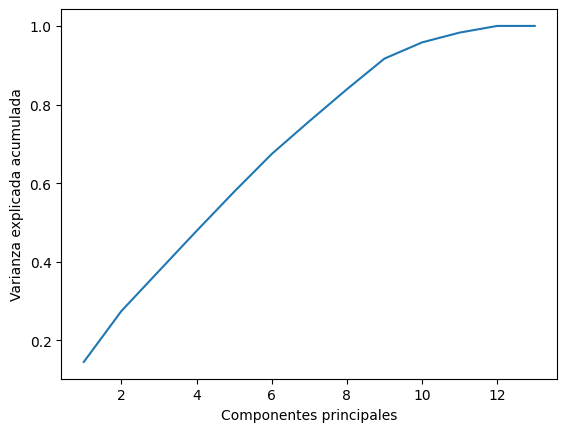

In [ ]:
sns.lineplot( x=range(1, num_variables+1), y=pca.explained_variance_ratio_.cumsum())
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada acumulada")

In [ ]:
pca= PCA(9)
pca.fit( scale_feature)

PCA(n_components=9)

In [ ]:
pd.DataFrame(pca.components_.T, index= datos_numericos.columns)

,0,1,2,3,4,5,6,7,8
Quantity,0.678010,-0.123031,0.018973,-0.019720,-0.038316,-0.121990,0.050500,0.025272,0.064585
Total,0.678336,-0.098972,-0.007081,-0.037478,-0.031378,-0.125725,0.021870,0.056340,0.106755
Rating,-0.053056,0.055206,0.087410,0.099042,0.016134,-0.228424,0.706322,-0.617112,0.191058
City_Naypyitaw,0.132490,0.646297,0.028490,0.020390,-0.000090,0.222286,0.109298,0.017048,0.062626
City_Yangon,-0.132214,-0.637885,-0.015217,0.052307,-0.053451,-0.248024,-0.028006,-0.102758,-0.078716
Customer type_Normal,-0.072234,-0.034408,0.115718,-0.178920,-0.006623,-0.139654,0.625484,0.657220,-0.323819
Gender_Male,-0.151535,-0.104164,0.341673,-0.065254,0.038585,-0.013625,0.006072,0.315992,0.861396
Product line_Fashion accessories,-0.101553,0.221181,-0.397500,-0.457962,-0.255491,-0.514679,-0.110447,-0.009899,0.136040
Product line_Food and beverages,-0.010865,0.109930,0.050228,0.815144,-0.103058,-0.255451,-0.046128,0.183707,-0.014086
Product line_Health and beauty,0.034319,0.041730,0.764314,-0.264829,0.154105,-0.060679,-0.172358,-0.187452,-0.251944


<Axes: >

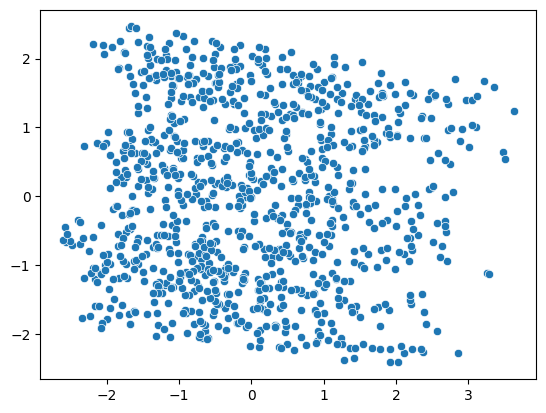

In [ ]:
z_componentes1= pca.fit_transform( scale_feature)

sns.scatterplot( x=z_componentes1[:,0], y=z_componentes1[:,1])


### K-Means

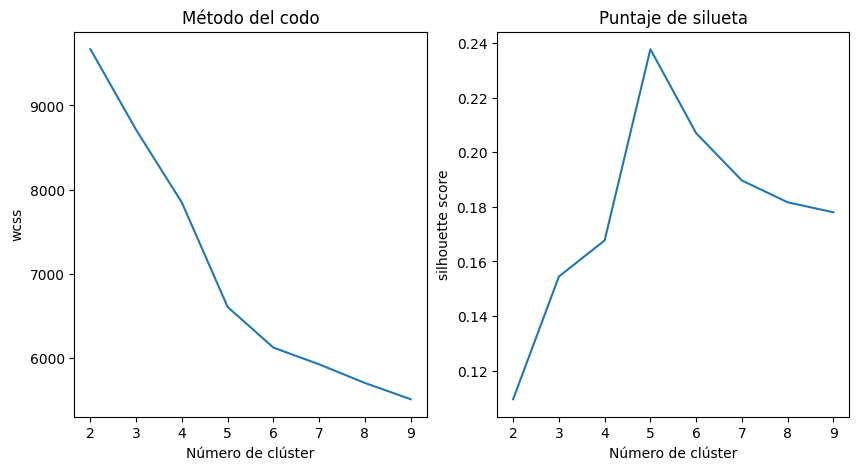

In [ ]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k, random_state=123)
  k_means.fit(z_componentes1)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(z_componentes1, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [ ]:
k_means= KMeans(5, random_state=123)
k_means.fit(z_componentes1)
labels_k_means2 = pd.Series(k_means.labels_)

#Frecuencia
counts = labels_k_means2.value_counts()
frequencies = labels_k_means2.value_counts(normalize=True) * 100

pd.DataFrame({'Counts': counts, 'Frequency (%)': frequencies})

,Counts,Frequency (%)
4,326,32.929293
1,177,17.878788
2,171,17.272727
0,166,16.767677
3,150,15.151515


### Cluster Jerárquico

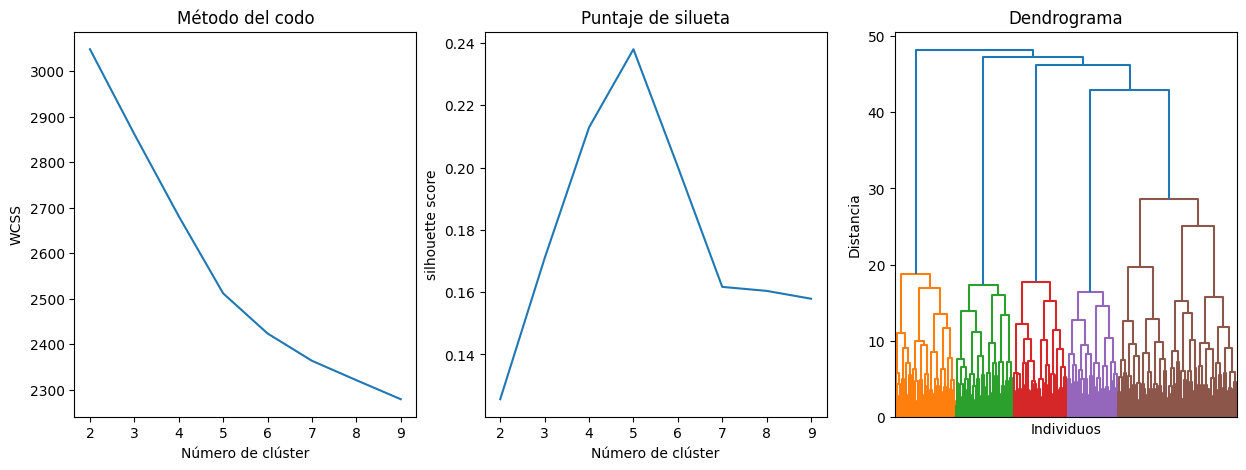

In [ ]:
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(z_componentes1)
  scaled_temp= pd.DataFrame(z_componentes1)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(z_componentes1,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(z_componentes1,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(z_componentes1, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [ ]:
hc=AgglomerativeClustering(5 )
hc.fit(scaled_features )
data["labels_hc"]= hc.labels_
data["labels_hc"] = data["labels_hc"].astype(str)
data["labels_hc"].value_counts()

,count
labels_hc,
0,330
3,178
2,174
4,166
1,152


labels_hc
0    0.330
3    0.178
2    0.174
4    0.166
1    0.152
Name: proportion, dtype: float64


<Axes: xlabel='labels_hc', ylabel='proportion'>

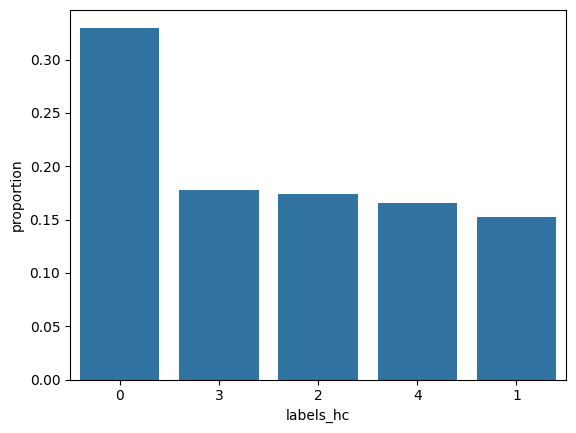

In [ ]:
print(data["labels_hc"].value_counts(normalize=True))
sns.barplot(data["labels_hc"].value_counts(normalize=True) )

In [ ]:
data.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating', 'labels_k_means', 'labels_hc'],
      dtype='object')

In [ ]:
tabla1 = data.groupby('labels_hc')["Product line"].value_counts(normalize=True)
px.bar(tabla1.reset_index(), x='labels_hc',y="proportion" , color='Product line', barmode='group')S

In [ ]:
tabla1 = data.groupby('labels_hc')["Customer type"].value_counts(normalize=True)
px.bar(tabla1.reset_index(), x='labels_hc',y="proportion" , color='Customer type', barmode='group')

In [ ]:
px.box(data, x='labels_hc', y='Quantity',color="labels_hc",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='Quantity: Boxplot por clúster')

In [ ]:
px.box(data, x='labels_hc', y='Total',color="labels_hc",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='Total: Boxplot por clúster')